In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle

import collections
import itertools
import tables
from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
# import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)



<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

### Enhancer-gene project pilot notebook


- mCG (not normalized, cluster level)
- RNA logTPM (normalized, cluster level) 
- mCH normalized by global mean (normalized, cluster level)
- ATAC logTPM (normalized, cluster level)


### Basic settings 

- gene annotation
- cluster annotation
- enhancers annotation
- gene features
- enhancer features

In [2]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

output_figures = '/cndd2/fangming/scf_enhancers/results/figures/{}_{{}}.{{}}'.format(today)
output_results = '/cndd2/fangming/scf_enhancers/results/{}_{{}}'.format(today)


In [3]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes['chrom'] = df_genes['chr'].apply(lambda x: x[3:])
df_genes = df_genes[df_genes['chrom'].isin(snmcseq_utils.get_mouse_chromosomes())]
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes['length'] = df_genes['end'] - df_genes['start']
print(df_genes.shape)
df_genes.head()

(51772, 10)


gene_id      gene_name   chr    start      end strand  \
0  ENSMUSG00000102693.1  4933401J01Rik  chr1  3073253  3074322      +   
1  ENSMUSG00000064842.1        Gm26206  chr1  3102016  3102125      +   
2  ENSMUSG00000051951.5           Xkr4  chr1  3205901  3671498      -   
3  ENSMUSG00000102851.1        Gm18956  chr1  3252757  3253236      +   
4  ENSMUSG00000103377.1        Gm37180  chr1  3365731  3368549      -   

              gene_type chrom                 gid  length  
0                   TEC     1  ENSMUSG00000102693    1069  
1                 snRNA     1  ENSMUSG00000064842     109  
2        protein_coding     1  ENSMUSG00000051951  465597  
3  processed_pseudogene     1  ENSMUSG00000102851     479  
4                   TEC     1  ENSMUSG00000103377    2818

In [4]:
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
gid_to_name = df_genes.set_index('gid')['gene_name']
df_genes_v2.head()

gene_id    chr      start        end strand  \
gene_name                                                                 
0610005C13Rik  ENSMUSG00000109644.1   chr7   45567794   45575327      -   
0610006L08Rik  ENSMUSG00000108652.1   chr7   74818818   74853813      -   
0610009B22Rik  ENSMUSG00000007777.9  chr11   51685386   51688874      -   
0610009E02Rik  ENSMUSG00000086714.1   chr2   26445696   26459390      +   
0610009L18Rik  ENSMUSG00000043644.4  chr11  120348678  120351190      +   

                                   gene_type chrom                 gid  length  
gene_name                                                                       
0610005C13Rik                  antisense_RNA     7  ENSMUSG00000109644    7533  
0610006L08Rik                        lincRNA     7  ENSMUSG00000108652   34995  
0610009B22Rik                 protein_coding    11  ENSMUSG00000007777    3488  
0610009E02Rik           processed_transcript     2  ENSMUSG00000086714   13694  
0610009L18Rik  bidirectional_promoter_lncRNA    11  ENSMUSG00000043644    2512

In [5]:
gid_to_name.head()

gid
ENSMUSG00000102693    4933401J01Rik
ENSMUSG00000064842          Gm26206
ENSMUSG00000051951             Xkr4
ENSMUSG00000102851          Gm18956
ENSMUSG00000103377          Gm37180
Name: gene_name, dtype: object

In [6]:
data_dir = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/'

In [7]:
# list of enhancers
f = os.path.join(data_dir, 'results/enhancers.bed')
df_enhs = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'clsts'])
df_enhs['length'] = df_enhs['end'] - df_enhs['start']
df_enhs['index'] = df_enhs.index.values
df_enhs['chrom'] = df_enhs['chr'].apply(lambda x: x[3:]) 
print(df_enhs.shape)
df_enhs.head()

(233524, 7)


chr    start      end  clsts  length  index chrom
0  chr1  3083769  3083816    NaN      47      0     1
1  chr1  3112234  3112467    NaN     233      1     1
2  chr1  3112770  3112986    NaN     216      2     1
3  chr1  3113717  3114035    NaN     318      3     1
4  chr1  3118790  3118935    NaN     145      4     1

In [8]:
# list of clusters
f = os.path.join(data_dir, 'ref/annotations_order.tsv')
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

### get features 

In [9]:
# global mC levels
import pickle as pkl

fs = [
    os.path.join(data_dir, 'results/cluster_global_mcg_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mcg_round3.pkl'),
]
global_mean_mcg = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mcg.append(pkl.load(fh))
global_mean_mcg = pd.concat(global_mean_mcg) 


fs = [
    os.path.join(data_dir, 'results/cluster_global_mch_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mch_round3.pkl'),
]
global_mean_mch = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mch.append(pkl.load(fh))
global_mean_mch = pd.concat(global_mean_mch)
    
print(global_mean_mcg.shape, global_mean_mch.shape)
global_mean_mcg.head()

(82,) (82,)


1-1     0.773445
1-2     0.774822
10-1    0.833052
2-1     0.787654
2-2     0.804645
dtype: float64

In [10]:
# gene rna
f = os.path.join(data_dir, 'results/gene_counts_smarter_cells_ethan38.tsv')
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
nclsts = gene_rna_clsts.shape[1]
print(gene_rna_clsts.shape)

# remove genes with coverage in less than half of clusters
cov_mat = (gene_rna_clsts > 0)
gene_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 1000 genes 
gene_rna_clsts = gene_rna_clsts.loc[gene_conds, clsts_conds]
print(gene_rna_clsts.shape)

# logtpm normalization
gene_lengths = df_genes.set_index('gid').reindex(gene_rna_clsts.index)['length'].dropna()
gene_lengths = gene_lengths.fillna(np.nanmean(gene_lengths))
gene_rna_clsts = snmcseq_utils.logtpm(gene_rna_clsts.loc[gene_lengths.index], gene_lengths)

print(gene_rna_clsts.shape)
gene_rna_clsts.head()

(32324, 39)
(20948, 38)
(20917, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2  \
ENSMUSG00000109644  0.077161  0.091720  0.074729  0.038471  0.013163   
ENSMUSG00000108652  0.001266  0.006267  0.000439  0.000865  0.000821   
ENSMUSG00000007777  2.446674  2.410288  2.450837  2.369418  2.375910   
ENSMUSG00000086714  0.375207  0.418962  0.375429  0.251558  0.474652   
ENSMUSG00000043644  1.219722  1.202714  1.368876  1.418651  1.424261   

                       2-2-1     2-3-1     2-3-2     2-3-3     3-1-1  ...  \
ENSMUSG00000109644  0.056907  0.061671  0.000000  0.000000  0.036800  ...   
ENSMUSG00000108652  0.000688  0.001187  0.000000  0.004307  0.000435  ...   
ENSMUSG00000007777  2.393247  2.428575  2.055402  2.422551  2.419142  ...   
ENSMUSG00000086714  0.399573  0.337472  0.000000  0.493305  0.325569  ...   
ENSMUSG00000043644  1.372149  1.209884  1.356782  1.188633  1.322994  ...   

                       6-4-2       6-5     7-1-1     7-1-2     7-2-1  \
ENSMUSG00000109644  0.692939  0.069381  0.194286  0.000000  0.158817   
ENSMUSG00000108652  0.000000  0.000952  0.000000  0.002837  0.001006   
ENSMUSG00000007777  2.601544  2.505518  2.465983  2.414289  2.451479   
ENSMUSG00000086714  0.412851  0.294404  0.489537  0.119979  0.292175   
ENSMUSG00000043644  1.534449  1.415919  1.820844  1.437500  1.689219   

                       7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
ENSMUSG00000109644  0.009621  0.089132  0.156354  0.000000  0.000000  
ENSMUSG00000108652  0.000000  0.000000  0.000409  0.000000  0.000000  
ENSMUSG00000007777  2.460925  2.464683  2.490120  2.446130  2.263220  
ENSMUSG00000086714  0.272975  0.412859  0.302445  0.269765  0.000000  
ENSMUSG00000043644  1.556682  1.557138  1.389810  1.241283  1.583789  

[5 rows x 38 columns]

In [11]:
# gene mch
f = os.path.join(data_dir, 'results/gene_counts_mch_mch_ethan38.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=0)
f = os.path.join(data_dir, 'results/gene_counts_mch_ch_ethan38.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=0)
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage genes
# remove low coverage clusters
base_call_cutoff = 1e3
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
gene_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the gene
gene_mch_c_clsts = c_table.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = mc_table.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()

(55487, 39) (55487, 39)
(39556, 38)
(39556, 38)
(39556, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2  \
ENSMUSG00000102693  1.044560  1.388850  1.814953  0.986151  1.137234   
ENSMUSG00000051951  0.585127  0.492982  0.405509  0.509483  0.519171   
ENSMUSG00000103377  0.626740  0.512025  0.425547  0.587109  0.574752   
ENSMUSG00000104017  0.579676  0.462759  0.387327  0.721597  0.792361   
ENSMUSG00000103025  0.642186  0.546094  0.462418  0.621182  0.532478   

                       2-2-1     2-3-1     2-3-2     2-3-3     3-1-1  ...  \
ENSMUSG00000102693  1.012576  1.489216  1.085170  1.015275  0.949874  ...   
ENSMUSG00000051951  0.479962  0.664061  0.627431  0.781421  0.512411  ...   
ENSMUSG00000103377  0.596842  0.727876  0.910802  0.896544  0.597430  ...   
ENSMUSG00000104017  0.671177  0.811555  0.614899  1.093287  0.622296  ...   
ENSMUSG00000103025  0.493473  0.720957  0.623816  0.906200  0.649551  ...   

                       6-4-2       6-5     7-1-1     7-1-2     7-2-1  \
ENSMUSG00000102693  1.104607  0.967632  1.201295  1.261993  1.113230   
ENSMUSG00000051951  0.586042  0.690053  0.667905  0.556561  0.483934   
ENSMUSG00000103377  0.356648  0.690416  1.573784  1.312456  1.371550   
ENSMUSG00000104017  0.800520  1.044661  0.616798  0.747225  0.624706   
ENSMUSG00000103025  0.865781  0.871531  0.760678  0.574916  0.697269   

                       7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
ENSMUSG00000102693  1.147272  1.132247  0.968678  0.981316  1.029372  
ENSMUSG00000051951  0.468551  0.328460  0.373701  0.910935  0.810503  
ENSMUSG00000103377  1.124712  0.397388  0.388527  0.711115  1.022159  
ENSMUSG00000104017  0.871620  0.515409  0.319068  0.868590  0.659482  
ENSMUSG00000103025  0.578430  0.290371  0.488555  0.966604  0.771126  

[5 rows x 38 columns]

In [12]:
# enhancer mcg
f = os.path.join(data_dir, 'results/enhancer_cluster_mcg.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
f = os.path.join(data_dir, 'results/enhancer_cluster_cg.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage enhs
# remove low coverage clusters
base_call_cutoff = 20
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 enhs are covered in that cell type
enh_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the enh
enh_mcg_c_clsts = c_table.loc[enh_cond, clst_cond]
enh_mcg_mc_clsts = mc_table.loc[enh_cond, clst_cond]
print(enh_mcg_c_clsts.shape, enh_mcg_mc_clsts.shape)

# get mcc
enh_mcg_clsts = snmcseq_utils.get_mcc_lite_v2(enh_mcg_c_clsts, enh_mcg_mc_clsts, base_call_cutoff=base_call_cutoff)
enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)
print(enh_mcg_clsts.shape)

# index
enh_mcg_clsts.index = df_enhs.set_index(['chrom', 'start', 'end']).reindex(enh_mcg_clsts.index)['index']
print(enh_mcg_clsts.shape)

del enh_mcg_c_clsts, enh_mcg_mc_clsts

print(enh_mcg_clsts.shape)
enh_mcg_clsts.head()

(233514, 38) (233514, 38)
(155652, 38) (155652, 38)
(155652, 38)
(155652, 38)
(155652, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2     2-2-1     2-3-1  \
index                                                                         
1      1.240298  1.248431  1.241011  1.220681  1.233649  1.222340  1.227358   
3      0.732653  0.633566  0.699519  0.218281  0.211427  0.147583  0.313127   
4      0.117538  0.072983  0.046292  0.948267  0.853397  1.017745  1.093087   
5      0.021914  0.000000  0.000000  0.027021  0.072489  0.071764  0.158069   
6      0.472017  0.397952  0.432056  0.264584  0.156398  0.253389  0.361300   

          2-3-2     2-3-3     3-1-1  ...     6-4-2       6-5     7-1-1  \
index                                ...                                 
1      1.252849  1.130344  1.236917  ...  1.102198  1.160278  1.164447   
3      0.743879  0.689585  0.351170  ...  0.366996  0.998848  0.952729   
4      0.636395  0.645230  1.020415  ...  0.629163  1.210724  0.604933   
5      0.186484  0.189072  0.184250  ...  0.184364  0.180213  0.893183   
6      0.298297  0.380712  0.356650  ...  0.371232  0.362874  0.356935   

          7-1-2     7-2-1     7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
index                                                                        
1      1.169190  1.153231  1.196036  1.175057  1.143372  1.240520  1.135905  
3      0.937336  0.649250  0.966029  0.656137  0.643699  0.692691  0.589149  
4      1.053982  0.607489  0.607537  0.613934  0.602296  0.648136  0.648404  
5      0.572816  0.178013  0.178027  0.179902  0.176491  0.189924  0.190003  
6      0.536903  0.358444  0.358471  0.362246  0.355379  0.382427  0.382585  

[5 rows x 38 columns]

In [13]:
# enhancer atac
f = os.path.join(data_dir, 'results/enhancer_cluster_atac.tsv')
enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=[0, 1, 2])
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

nclsts = enh_atac_clsts.shape[1]
print(enh_atac_clsts.shape)

# remove enhs with coverage in less than half of clusters
# remove clusters with low coverage
cov_mat = (enh_atac_clsts > 0)
enh_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 10000 enhs 
enh_atac_clsts = enh_atac_clsts.loc[enh_conds, clsts_conds]
print(enh_atac_clsts.shape)

# logtpm normalization
enh_lengths = df_enhs.copy()
enh_lengths['start'] = df_enhs['start'] - 1000
enh_lengths['end'] = df_enhs['end'] + 1000
enh_lengths['length'] = df_enhs['length'] + 2*1000 # 1kb flanking
enh_lengths = enh_lengths.set_index(['chr', 'start', 'end']).reindex(enh_atac_clsts.index) 

enh_atac_clsts = snmcseq_utils.logtpm(enh_atac_clsts, enh_lengths['length'])
enh_atac_clsts.index = enh_lengths['index']
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

(233524, 38)
(233524, 38)
(225713, 38)
(225713, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2     2-2-1     2-3-1  \
index                                                                         
0      0.130886  0.119725  0.000000  0.096849  0.192041  0.084071  0.000000   
1      0.099659  0.047817  0.000000  0.227126  0.214111  0.077658  0.181955   
2      0.239656  0.246094  0.000000  0.454261  0.484983  0.590365  0.491015   
3      0.262038  0.278067  0.000000  0.458675  0.489559  0.617380  0.477878   
4      1.205729  1.191456  1.167327  1.167571  1.150293  1.174013  1.042267   

          2-3-2     2-3-3     3-1-1  ...     6-4-2       6-5     7-1-1  \
index                                ...                                 
0      0.000000  0.000000  0.110173  ...  0.564528  0.608619  0.000000   
1      0.809963  0.000000  0.101991  ...  0.629618  0.000000  0.433551   
2      1.079025  0.000000  0.470720  ...  0.879333  0.000000  0.435650   
3      0.796291  0.000000  0.470562  ...  0.862421  0.000000  0.000000   
4      0.000000  1.252377  1.045489  ...  0.643045  0.295275  0.996498   

          7-1-2     7-2-1     7-2-2     8-1-1  8-2-1     9-1-1  9-2-1  
index                                                                  
0      0.000000  0.000000  0.000000  0.000000    0.0  0.164258    0.0  
1      0.000000  0.000000  0.000000  0.000000    0.0  0.152714    0.0  
2      0.706488  0.411634  0.000000  0.746975    0.0  0.523153    0.0  
3      0.690856  0.399770  0.000000  0.730996    0.0  0.481399    0.0  
4      0.865335  0.808972  0.971425  1.182083    0.0  0.473350    0.0  

[5 rows x 38 columns]

### Shared enhancers, shared genes, shared clusters, and nan check

In [14]:
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

shared_genes = np.intersect1d(gene_rna_clsts.index.values, gene_mch_clsts.index.values)
shared_enhs = np.intersect1d(enh_mcg_clsts.index.values, enh_atac_clsts.index.values) 
shared_clusters = np.array(list(set(gene_rna_clsts.columns.tolist())
                              & set(gene_mch_clsts.columns.tolist())
                              & set(enh_mcg_clsts.columns.tolist())
                              & set(enh_atac_clsts.columns.tolist())
                        ))
print(shared_genes.shape, shared_enhs.shape, shared_clusters.shape)
print(shared_genes[:2])
print(shared_enhs[:2])
print(shared_clusters[:2])


(20917, 38)
(39556, 38)
(155652, 38)
(225713, 38)
(19078,) (152104,) (38,)
['ENSMUSG00000000001' 'ENSMUSG00000000028']
[1 3]
['5-2-2' '6-4-2']


In [15]:
gene_rna_clsts = gene_rna_clsts.loc[shared_genes, shared_clusters]
gene_mch_clsts = gene_mch_clsts.loc[shared_genes, shared_clusters]
enh_mcg_clsts = enh_mcg_clsts.loc[shared_enhs, shared_clusters]
enh_atac_clsts = enh_atac_clsts.loc[shared_enhs, shared_clusters]
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

(19078, 38)
(19078, 38)
(152104, 38)
(152104, 38)


In [16]:
print(gene_rna_clsts.isnull().sum().sum())
print(gene_mch_clsts.isnull().sum().sum())
print(enh_mcg_clsts.isnull().sum().sum())
print(enh_atac_clsts.isnull().sum().sum())

0
0
0
0


### Get nearest gene info for each region

In [17]:
f = os.path.join(data_dir, 'results/enhancer_nearest_genes.bed')
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info.head()

# regions_info = regions_info.iloc[:, [0,1,2,8,9,11]] 
regions_info = regions_info.iloc[:, [0,1,2,7,8,9,10,11]] 
regions_info.columns = ['chr', 'start', 'end', 'transcript_id', 'transcript_name', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, df_enhs, on=['chr', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()


(224577, 12)


chr    start      end         transcript_id    transcript_name  \
0  chr1  3083769  3083816  ENSMUST00000193812.1  4933401J01Rik-201   
1  chr1  3112234  3112467  ENSMUST00000082908.1        Gm26206-201   
2  chr1  3112770  3112986  ENSMUST00000082908.1        Gm26206-201   
3  chr1  3113717  3114035  ENSMUST00000082908.1        Gm26206-201   
4  chr1  3118790  3118935  ENSMUST00000082908.1        Gm26206-201   

                gene_id      gene_name  distance  clsts  length  index chrom  
0  ENSMUSG00000102693.1  4933401J01Rik     10516    NaN      47      0     1  
1  ENSMUSG00000064842.1        Gm26206     10218    NaN     233      1     1  
2  ENSMUSG00000064842.1        Gm26206     10754    NaN     216      2     1  
3  ENSMUSG00000064842.1        Gm26206     11701    NaN     318      3     1  
4  ENSMUSG00000064842.1        Gm26206     16774    NaN     145      4     1

## Correlation  

In [18]:
# select common clusters
# clusters_selected = np.array(list(clst_annot.keys())) 

# clusters_selected = np.intersect1d(gene_rna_clsts.columns.values, enh_mcg_clsts.columns.values)
# clusters_selected_labels = np.array([str(clst)+" "+clst_annot[clst] for clst in clusters_selected])
# clusters_selected_labels

#### Length of enhancers 

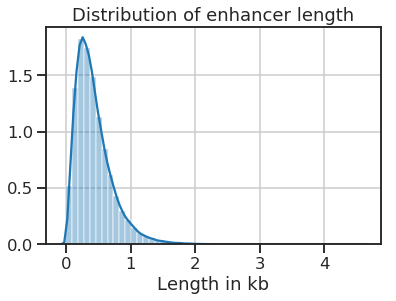

In [19]:
lens = df_enhs.loc[shared_enhs, 'length']
fig, ax = plt.subplots()
sns.distplot(lens.values/1000, ax=ax)
ax.set_xlabel('Length in kb')
ax.set_title('Distribution of enhancer length')
output_name = 'Enhancer length distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()


In [20]:
# full correlation

# gene 
_x_features = shared_genes 
_X = gene_rna_clsts.values
# # enhancer
_y_features = shared_enhs
_Y = enh_mcg_clsts.values 

# # enhancer
_y2_features = shared_enhs
_Y2 = enh_atac_clsts.values 
print(_X.shape, _Y.shape, _Y2.shape)

# row genes_list 
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
genes_list = df_genes.set_index('gid').reindex(shared_genes).reset_index().copy()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)

# row ens_list
ens_list = df_enhs.set_index('index').loc[shared_enhs].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)

print(ens_list.shape, genes_list.shape)
genes_list.head()

(19078, 38) (152104, 38) (152104, 38)
(152104, 8) (19078, 11)


gid                gene_id gene_name    chr      start  \
0  ENSMUSG00000000001   ENSMUSG00000000001.4     Gnai3   chr3  108107280   
1  ENSMUSG00000000028  ENSMUSG00000000028.14     Cdc45  chr16   18780447   
2  ENSMUSG00000000037  ENSMUSG00000000037.16     Scml2   chrX  161117193   
3  ENSMUSG00000000049  ENSMUSG00000000049.11      Apoh  chr11  108343354   
4  ENSMUSG00000000056   ENSMUSG00000000056.7      Narf  chr11  121237253   

         end strand       gene_type chrom  length        tss  
0  108146146      -  protein_coding     3   38866  108146146  
1   18811987      -  protein_coding    16   31540   18811987  
2  161258213      +  protein_coding     X  141020  161117193  
3  108414396      +  protein_coding    11   71042  108343354  
4  121255856      +  protein_coding    11   18603  121237253

In [21]:
_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)
_Y2_ranks = snmcseq_utils.rank_rows(_Y2)

In [22]:
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

KB = 1000
window_size = 2000*KB # (+/- 1Mb)
inner_window_size = 4*KB #(+/- 2kb)
to_evals = [] 

ti = time.time()
# ens, gene
for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals.append((gene['gid'], ens))
to_evals = pd.DataFrame(to_evals, columns=['gene', 'ens'])

output_toevals = output_results.format('to_evals.tsv')
print(to_evals.shape)
to_evals.head()
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)

0 0.00896453857421875
1000 27.829460620880127
2000 57.12797927856445
3000 87.39655494689941
4000 117.92459988594055
5000 146.3091173171997
6000 175.6931312084198
7000 205.62098503112793
8000 234.11585092544556
9000 263.15452766418457
10000 292.7207260131836
11000 322.1017003059387
12000 350.8582968711853
13000 379.23959136009216
14000 407.43203616142273
15000 435.1191644668579
16000 461.01470041275024
17000 488.6903851032257
18000 516.4547724723816
19000 544.4501361846924
(2589994, 2)


In [23]:

# # output_toevals = output_results.format('to_evals.tsv')
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)

In [24]:
f = output_results.format('to_evals.tsv')
to_evals = pd.read_csv(f, sep="\t")
print(to_evals.shape)
to_evals.head()

(2589994, 2)


gene     ens
0  ENSMUSG00000000001  147520
1  ENSMUSG00000000001  147522
2  ENSMUSG00000000001  147523
3  ENSMUSG00000000001  147527
4  ENSMUSG00000000001  147528

In [25]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals['ens'].values)
_y2_idx = snmcseq_utils.get_index_from_array(_y2_features, to_evals['ens'].values)

to_evals['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals['val2'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y2_ranks[_y2_idx]) 

_X_ranks
to_evals['val_clustershuffled'] = snmcseq_utils.vcorrcoef(_X_ranks[:, np.random.permutation(_X_ranks.shape[1])][_x_idx], 
                                                          _Y_ranks[:, np.random.permutation(_Y_ranks.shape[1])][_y_idx]) 

to_evals['val2_clustershuffled'] = snmcseq_utils.vcorrcoef(_X_ranks[:, np.random.permutation(_X_ranks.shape[1])][_x_idx], 
                                                           _Y2_ranks[:, np.random.permutation(_Y2_ranks.shape[1])][_y2_idx]) 

to_evals['dist'] = np.abs(ens_list.set_index('index').loc[to_evals['ens'].values, 'center'].values 
                        - genes_list.set_index('gid').loc[to_evals['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals.head()

126.06625866889954


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist  
0             -0.049349  995118  
1              0.105591  985740  
2              0.014772  983725  
3              0.184594  970444  
4              0.147609  969372

In [26]:
# shuffle

ti = time.time()
np.random.seed(0)

to_evals_shuffled = [] 
# shuffle gene_name label
genes_list_shuffle = genes_list.copy()
# genes_list_shuffle['gene_name'] = np.random.permutation(genes_list_shuffle['gene_name'].values)
genes_list_shuffle['gid'] = np.random.permutation(genes_list_shuffle['gid'].values)

# ens, gene
for idx, gene in genes_list_shuffle.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals_shuffled.append((gene['gid'], ens))
to_evals_shuffled = pd.DataFrame(to_evals_shuffled, columns=['gene', 'ens'])

print(len(to_evals_shuffled))

f = output_results.format('to_evals_shuffled.tsv')
print(to_evals_shuffled.shape)
to_evals_shuffled.to_csv(f, sep="\t", header=True, index=False)
to_evals_shuffled.head()

0 0.012111186981201172
1000 28.305356740951538
2000 58.17983889579773
3000 88.82633900642395
4000 119.02159667015076
5000 147.9327735900879
6000 176.7464210987091
7000 206.28710746765137
8000 234.0969500541687
9000 262.70206451416016
10000 291.8556592464447
11000 321.51797318458557
12000 349.86347246170044
13000 377.93403840065
14000 406.22969818115234
15000 433.4369773864746
16000 460.12140679359436
17000 487.6059067249298
18000 516.5736396312714
19000 544.06982421875
2589994
(2589994, 2)


gene     ens
0  ENSMUSG00000020020  147520
1  ENSMUSG00000020020  147522
2  ENSMUSG00000020020  147523
3  ENSMUSG00000020020  147527
4  ENSMUSG00000020020  147528

In [27]:
f = output_results.format('to_evals_shuffled.tsv')
to_evals_shuffled = pd.read_csv(f, sep="\t")
print(to_evals_shuffled.shape)
to_evals_shuffled.head()

(2589994, 2)


gene     ens
0  ENSMUSG00000020020  147520
1  ENSMUSG00000020020  147522
2  ENSMUSG00000020020  147523
3  ENSMUSG00000020020  147527
4  ENSMUSG00000020020  147528

In [28]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals_shuffled['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 

_y2_idx = snmcseq_utils.get_index_from_array(_y2_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val2'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y2_ranks[_y2_idx]) 

to_evals_shuffled['dist'] = np.abs(ens_list.set_index('index').loc[to_evals_shuffled['ens'].values, 'center'].values 
                        - genes_list_shuffle.set_index('gid').loc[to_evals_shuffled['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals_shuffled.head()

64.31717252731323


gene     ens       val      val2    dist
0  ENSMUSG00000020020  147520 -0.183718  0.297297  995118
1  ENSMUSG00000020020  147522 -0.167961  0.466900  985740
2  ENSMUSG00000020020  147523 -0.233395  0.209323  983725
3  ENSMUSG00000020020  147527 -0.081300  0.042784  970444
4  ENSMUSG00000020020  147528 -0.409782  0.039063  969372

In [29]:
# mean within a distance bin
n = 100
_dist = np.linspace(0, window_size/(2*KB), n)


_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val']
_mval = _tmp.mean()
_stdval = _tmp.std()
_sizes = _tmp.size()

_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val2']
_mval2 = _tmp.mean()
_stdval2 = _tmp.std()
_sizes2 = _tmp.size()



print(_dist.shape, _mval.shape, _mval2.shape)

(100,) (100,) (100,)


In [30]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

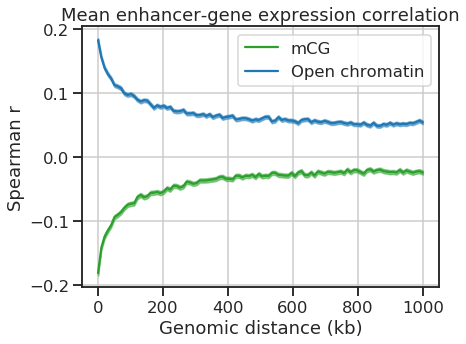

In [31]:
scale = 0.8
fig, ax = plt.subplots(figsize=(8*scale,6*scale))
x = to_evals['dist'].values/1000, 
y = to_evals['val'].values, 
y2 = to_evals['val2'].values, 

yerr = 1.96*_stdval/np.sqrt(_sizes)
yerr2 = 1.96*_stdval2/np.sqrt(_sizes2)
ax.plot(
    _dist, _mval,
    '-',
    c=mod_palette['mc'],
    label='mCG',
    markersize=5,
)
ax.fill_between(_dist, _mval-yerr, _mval+yerr, color=mod_palette['mc'], alpha=0.5)

ax.plot(
    _dist, _mval2,
    '-',
    c=mod_palette['atac'],
    label='Open chromatin',
    markersize=5,
)
ax.fill_between(_dist, _mval2-yerr2, _mval2+yerr2, color=mod_palette['atac'], alpha=0.5)

ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Mean enhancer-gene expression correlation')
output_name = 'line_distance_vs_spearmanr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

### Statistical evaluation 
compute local FDR: 
- histogram -> density estimation (interpolate) -> cdf (cumsum), ratio of cdf
- quantile ranking (cdf) -> interpolate -> ratio of cdf

#### Setting up 

In [32]:
def bin_mean(x, y, bins):
    """Bin x according to bins, return bins, y_mean
    """
    # bin _x and mean_y
    _df = pd.DataFrame()
    _df['bin'] = np.digitize(_x, bins)
    _df['_y'] = _y
    _y_mean = _df.groupby('bin').mean()['_y']
    
    return bins[_y_mean.index], _y_mean.values

def fdr(x, x_bck, y_bck, x_fr, y_fr):
    """
    """
    return (np.interp(x, x_bck, y_bck))/(np.interp(x, x_fr, y_fr)+1e-6)

def pvalue(x, x_bck, y_bck):
    """
    """
    return np.interp(x, x_bck, y_bck)


In [33]:
regions = df_enhs # back compatibility

In [34]:
# randomly sample many genes and enhancers
ti = time.time()

p = 0.05
np.random.seed(0)
_x_selected_idx = np.arange(len(_x_features))
_x_selected_features = _x_features[_x_selected_idx]

_sampled = np.random.rand(len(_y_features))<p
_y_selected_idx = np.arange(len(_y_features))[_sampled]
_y_selected_features = _y_features[_y_selected_idx]

_y2_selected_idx = np.arange(len(_y2_features))[_sampled]
_y2_selected_features = _y2_features[_y2_selected_idx]

# same chrom or not
x_chroms = df_genes.set_index('gid').reindex(_x_selected_features)['chrom'].values
y_chroms = regions.set_index('index').reindex(_y_selected_features)['chrom'].values

corr = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], 
                                       _Y[_y_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr2 = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], 
                                       _Y2[_y2_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr_cis_mask = np.zeros_like(corr)
corr_cis_mask2 = np.zeros_like(corr2)
for i, x_chrom in enumerate(x_chroms):
    for j, y_chrom in enumerate(y_chroms):
        if x_chrom == y_chrom:
            corr_cis_mask[i,j] = 1
            corr_cis_mask2[i,j] = 1
            
corr_cis = corr[corr_cis_mask.nonzero()]
corr_cis2 = corr2[corr_cis_mask2.nonzero()]
print(time.time()-ti)

137.53987097740173


In [35]:
labels = [
        'All',
        'Same chrom',
        '<100kb shuffled (gene label)',
        '<100kb',
        '<200kb',
        '<500kb',
    
        '<100kb shuffled (cluster label)',
         ]

corr_tracks = [
       corr.flatten(),
       corr_cis,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=500*KB, 'val'].values,
    
       to_evals.loc[to_evals['dist']<=100*KB, 'val_clustershuffled'].values,
      ]

corr_tracks2 = [
       corr2.flatten(),
       corr_cis2,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=500*KB, 'val2'].values,
    
       to_evals.loc[to_evals['dist']<=100*KB, 'val2_clustershuffled'].values,
      ]

subsample_rates = [
                  0.01,
                  0.1,
                  1,
                  1,
                  1,
                  1,
    
                  1,
                 ]


np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]
corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks2))]


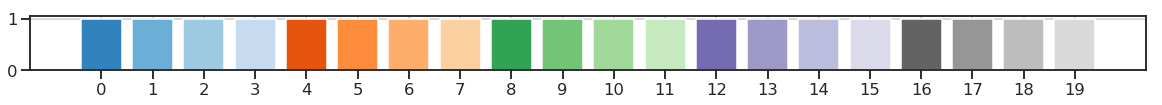

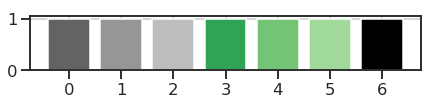

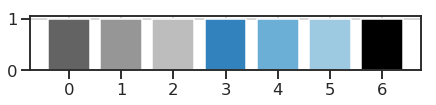

In [36]:
cm = plt.cm.tab20c.colors
# colors = [cm[16], cm[17], cm[18], cm[0], cm[1], cm[2], ]
# colors2 = [cm[16], cm[17], cm[18], cm[4], cm[5], cm[6], ]
colors = [cm[16], cm[17], cm[18], cm[8], cm[9], cm[10], 'black']
colors2 = [cm[16], cm[17], cm[18], cm[0], cm[1], cm[2], 'black']

n = len(cm)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=list(cm))
ax.set_xticks(np.arange(n))
plt.show()

n = len(colors)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=colors)
ax.set_xticks(np.arange(n))
plt.show()

n = len(colors2)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=colors2)
ax.set_xticks(np.arange(n))
snmcseq_utils.savefig(fig, output_figures.format('palette', 'pdf'))
plt.show()

In [37]:
# FDR

bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks[0])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck, y_smooth_bck)
to_evals['pvalues'] = pvalue(to_evals['val'].values, x_smooth_bck, y_smooth_bck)

# fore-ground - 2
# fdrs = []
for corr_track, track_name in zip(corr_tracks[3:], labels[3:]):
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
#     fdrs.append(fdr(bins_eval, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr{}'.format(track_name)] = fdr(to_evals['val'].values, 
                                               x_smooth_bck, y_smooth_bck, 
                                               x_smooth_fr0, y_smooth_fr0)

# FDR2
bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks2[0])
_y = 1 - np.arange(len(_x))/len(_x) # flipped cumulative function
x_smooth_bck2, y_smooth_bck2 = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck2, y_smooth_bck2)
to_evals['pvalues2'] = pvalue(to_evals['val2'].values, x_smooth_bck2, y_smooth_bck2)

# fore-ground - 2
# fdrs = []
for corr_track, track_name in zip(corr_tracks2[3:], labels[3:]):
    _x = np.sort(corr_track)
    _y = 1 - np.arange(len(_x))/len(_x) # flipped cumulative function
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
#     fdrs.append(fdr(bins_eval, x_smooth_bck2, y_smooth_bck2, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr2{}'.format(track_name)] = fdr(to_evals['val2'].values, 
                                                x_smooth_bck2, y_smooth_bck2, 
                                                x_smooth_fr0, y_smooth_fr0)

In [38]:
to_evals.head()

gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  
0    0.872822                             1.955898  
1    0.987476                             0.959470  
2    0.922832                             1.273339  
3    0.880982                             1.812516  
4    0.862033                             2.191506

In [39]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


num_sig track_name
0     7918      2-100
1      334    100-200
2       21    200-300
3        2    300-400
4        0    400-500

In [40]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val2'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val2'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val2'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val2'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val2'].values,
})

res_num_sig2 = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = 1 - np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck2, y_smooth_bck2, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig2.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig2 = pd.DataFrame(res_num_sig2)
print(res_num_sig2.shape)
res_num_sig2.head()

(5, 2)


num_sig track_name
0     3897      2-100
1       32    100-200
2       35    200-300
3        0    300-400
4        2    400-500

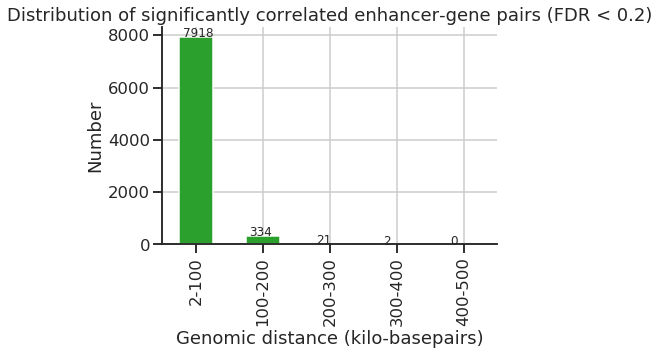

In [41]:
output_name = 'FDR_number'
fig, ax = plt.subplots()
res_num_sig.plot.bar(ax=ax, color=mod_palette['mc'], legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

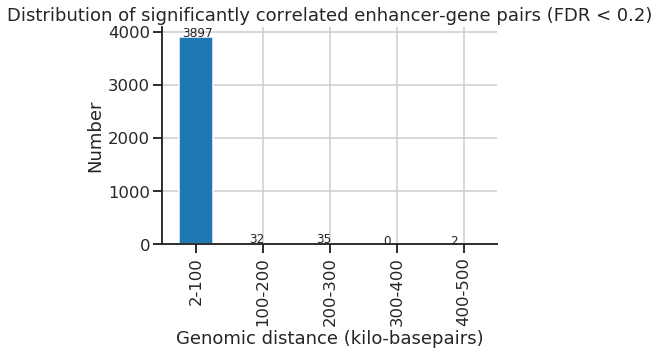

In [42]:
output_name = 'FDR_number2'
fig, ax = plt.subplots()
res_num_sig2.plot.bar(ax=ax, color=mod_palette['atac'], legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig2['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

#### Test individual pairs

In [43]:
to_evals.head()

gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000000001  147520 -0.157895  0.127913            -0.169712   
1  ENSMUSG00000000001  147522  0.027465 -0.307145             0.064887   
2  ENSMUSG00000000001  147523 -0.040376  0.011489            -0.155487   
3  ENSMUSG00000000001  147527 -0.070795  0.111719            -0.088084   
4  ENSMUSG00000000001  147528  0.012583  0.150673            -0.036218   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
0             -0.049349  995118  0.288079   0.674683   0.736811   0.827139   
1              0.105591  985740  0.561881   0.830849   0.867082   0.917381   
2              0.014772  983725  0.457686   0.780196   0.825259   0.889141   
3              0.184594  970444  0.411564   0.755088   0.804341   0.874375   
4              0.147609  969372  0.539123   0.819981   0.858026   0.911467   

   fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
0                            1.647931  0.383141    0.745977    0.797076   
1                            0.958300  0.935264    0.973809    0.979844   
2                            1.089312  0.580703    0.841673    0.874844   
3                            1.183332  0.410358    0.761056    0.809464   
4                            0.979843  0.345993    0.725803    0.780447   

   fdr2<500kb  fdr2<100kb shuffled (cluster label)  
0    0.872822                             1.955898  
1    0.987476                             0.959470  
2    0.922832                             1.273339  
3    0.880982                             1.812516  
4    0.862033                             2.191506

In [44]:
def estimate_frac_tps(pvalues, bin_n=100, frac_bin_null=0.05):
    """
    """
    y = np.sort(pvalues)
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = y_norm[-int(frac_bin_null*bin_n):].mean()
    frac_tp = 1 - null_level 
    
    return frac_tp, null_level, bin_counts, bin_edges, y_norm
    


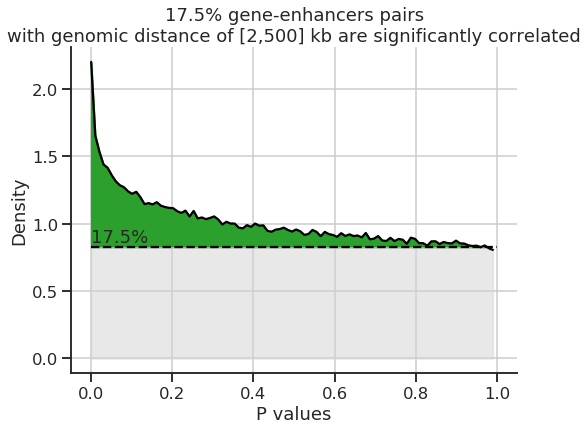

In [45]:
# plot pvalues
output_name = 'fraction-of-h1-one-example'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues'].sort_values().values
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color=mod_palette['mc'])
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)

ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

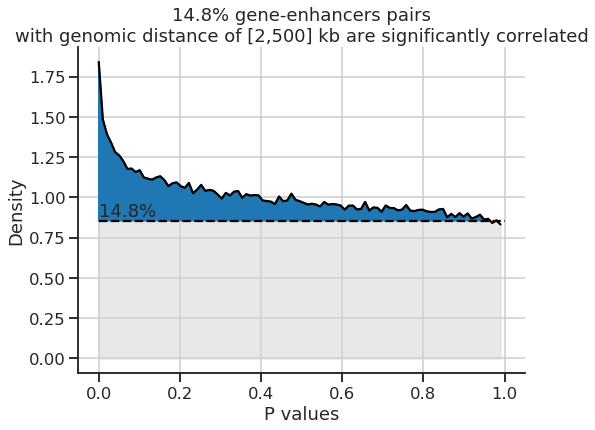

In [46]:
# plot pvalues
output_name = 'fraction-of-h1-one-example2'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues2'].sort_values().values
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color=mod_palette['atac'])
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)


ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [47]:
frac_tps = []
num_tps = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues'].values
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)
    frac_tps.append(frac_tp)
    num_tps.append(len(y)*frac_tp)
    
    
frac_tps2 = []
num_tps2 = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues2'].values
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)
    frac_tps2.append(frac_tp)
    num_tps2.append(len(y)*frac_tp)

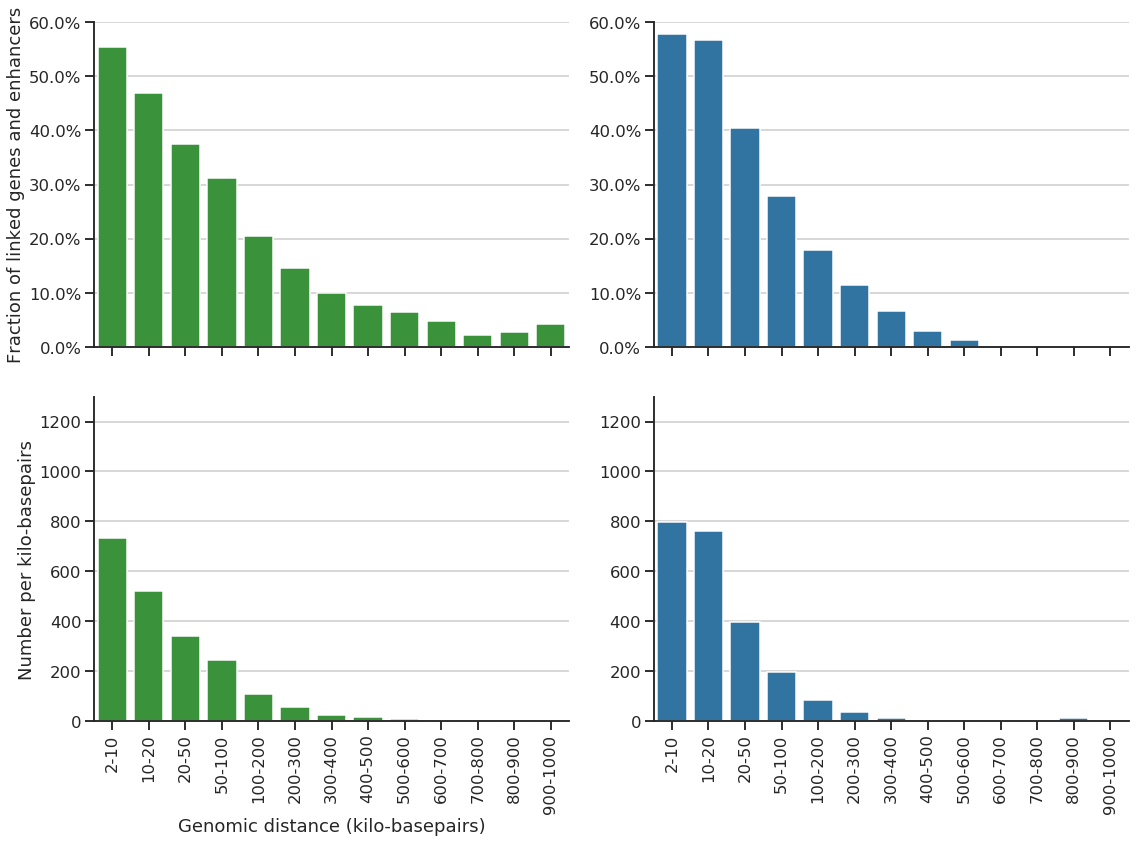

In [48]:
output_name = 'fraction-of-h1-summary'

dists_kb_plot = np.hstack([[2], dists_kb])

df_plot = pd.DataFrame(np.vstack([dists_kb, frac_tps]).T, columns=['x', 'y'])
df_plot['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot['num'] = np.array(num_tps)*np.array(frac_tps)
df_plot['num_norm'] = df_plot['num']/df_plot['length']

df_plot2 = pd.DataFrame(np.vstack([dists_kb, frac_tps2]).T, columns=['x', 'y'])
df_plot2['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot2['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot2['num'] = np.array(num_tps2)*np.array(frac_tps2)
df_plot2['num_norm'] = df_plot2['num']/df_plot2['length']



fig, axs = plt.subplots(2, 2, figsize=(8*2,6*2), sharex=True)
ax = axs[0, 0]
color = mod_palette['mc']
sns.barplot(x='x_formatted', y='y', data=df_plot, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Fraction of linked genes and enhancers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)
ax.set_ylim([0, 0.6])

ax = axs[0, 1]
color = mod_palette['atac']
sns.barplot(x='x_formatted', y='y', data=df_plot2, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)
ax.set_ylim([0, 0.6])

ax = axs[1, 0]
color = mod_palette['mc']
sns.barplot(x='x_formatted', y='num_norm', data=df_plot, color=color, ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Number per kilo-basepairs')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)
ax.set_ylim([0, 1300])

ax = axs[1, 1]
color = mod_palette['atac']
sns.barplot(x='x_formatted', y='num_norm', data=df_plot2, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)
ax.set_ylim([0, 1300])

fig.tight_layout()
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()



In [49]:
# significant ones
sig_cond = (
    ((to_evals['fdr<100kb']<0.2) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr<200kb']<0.2) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr<500kb']<0.2) & (to_evals['dist']<500*KB))
)

top_sig = to_evals[sig_cond].sort_values(['val']) #.head(30)
top_sig['gene_name'] = gid_to_name.loc[top_sig['gene'].values].values

top_sig = pd.merge(top_sig, ens_list, left_on='ens', right_on='index')
top_sig_genes = top_sig.groupby('gene').size().sort_values(ascending=False).index.values
top_sig_ens = top_sig.groupby('ens').size().sort_values(ascending=False).index.values

n_pair, n_enh, n_gene = len(top_sig), len(top_sig_ens), len(top_sig_genes)
print('{} significantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair, n_enh, len(_y_features), n_gene, len(_x_features)) 
     )
top_sig.head()

10156 significantly correlated enhancer-gene pairs
8891/152104 enhancers 2443/19078 genes


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000019943   27025 -0.935879  0.570631             0.201226   
1  ENSMUSG00000000861   32345 -0.935223  0.643287             0.318963   
2  ENSMUSG00000085516   32345 -0.664952  0.487909             0.212605   
3  ENSMUSG00000026235    6722 -0.931065  0.399497            -0.198818   
4  ENSMUSG00000049556  221850 -0.928439  0.317431            -0.074953   

   val2_clustershuffled    dist       pvalues  fdr<100kb  fdr<200kb  ...  \
0             -0.015210   14022  6.914357e-07   0.121256   0.190457  ...   
1              0.311741   40657  6.914357e-07   0.106202   0.169363  ...   
2              0.175621   54111  4.477577e-03   0.177417   0.249835  ...   
3              0.044534   56568  6.914357e-07   0.059453   0.099541  ...   
4              0.072109  167710  6.914357e-07   0.040442   0.067900  ...   

   fdr2<100kb shuffled (cluster label)      gene_name   index    chr  \
0                           246.577398         Atp2b1   27025  chr10   
1                           436.281051         Bcl11a   32345  chr11   
2                            45.678671  4930538E20Rik   32345  chr11   
3                            16.201208          Epha4    6722   chr1   
4                             7.033872         Lingo1  221850   chr9   

      start       end  clsts length  chrom    center  
0  98927814  98929042    NaN   1228     10  98928428  
1  24117705  24119721    NaN   2016     11  24118713  
2  24117705  24119721    NaN   2016     11  24118713  
3  77457469  77459572    NaN   2103      1  77458520  
4  56628060  56629457    NaN   1397      9  56628758  

[5 rows x 26 columns]

In [50]:
# sig2nificant ones
sig2_cond = (
    ((to_evals['fdr2<100kb']<0.2) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr2<200kb']<0.2) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr2<500kb']<0.2) & (to_evals['dist']<500*KB))
)

top_sig2 = to_evals[sig2_cond].sort_values(['val2'], ascending=False) #.head(30)
top_sig2['gene_name'] = gid_to_name.loc[top_sig2['gene'].values].values

top_sig2 = pd.merge(top_sig2, ens_list, left_on='ens', right_on='index')
top_sig2_genes = top_sig2.groupby('gene').size().sort_values(ascending=False).index.values
top_sig2_ens = top_sig2.groupby('ens').size().sort_values(ascending=False).index.values

n_pair2, n_enh2, n_gene2 = len(top_sig2), len(top_sig2_ens), len(top_sig2_genes)
print('{} sig2nificantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair2, n_enh2, len(_y_features), n_gene2, len(_x_features)) 
     )
top_sig2.head()

4707 sig2nificantly correlated enhancer-gene pairs
4240/152104 enhancers 1672/19078 genes


gene     ens       val      val2  val_clustershuffled  \
0  ENSMUSG00000096014  205278 -0.700186  0.916402             0.212168   
1  ENSMUSG00000008489  160142 -0.755334  0.904804            -0.046723   
2  ENSMUSG00000042064  127563 -0.505416  0.904147             0.157019   
3  ENSMUSG00000074622  136697  0.603677  0.899333            -0.023744   
4  ENSMUSG00000074623  136697  0.282416  0.689682            -0.080862   

   val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  ...  \
0             -0.043878   67889  0.002446   0.143979   0.208865  ...   
1              0.028559   37984  0.000749   0.092401   0.140621  ...   
2              0.121348  120670  0.029456   0.328219   0.418228  ...   
3             -0.044316    3137  0.990945   0.996607   0.997546  ...   
4              0.035124   36040  0.867690   0.953531   0.964423  ...   

   fdr2<100kb shuffled (cluster label)  gene_name   index   chr      start  \
0                             0.134780       Sox1  205278  chr8   12326999   
1                             0.134780     Elavl2  160142  chr4   91362228   
2                             0.134780      Myo3b  127563  chr2   70159496   
3                             0.134780       Mafb  136697  chr2  160369325   
4                           235.127763      Gm826  136697  chr2  160369325   

         end  clsts length  chrom     center  
0   12327814    NaN    815      8   12327406  
1   91363375    NaN   1147      4   91362801  
2   70160097    NaN    601      2   70159796  
3  160371080    NaN   1755      2  160370202  
4  160371080    NaN   1755      2  160370202  

[5 rows x 26 columns]

#### Plots 

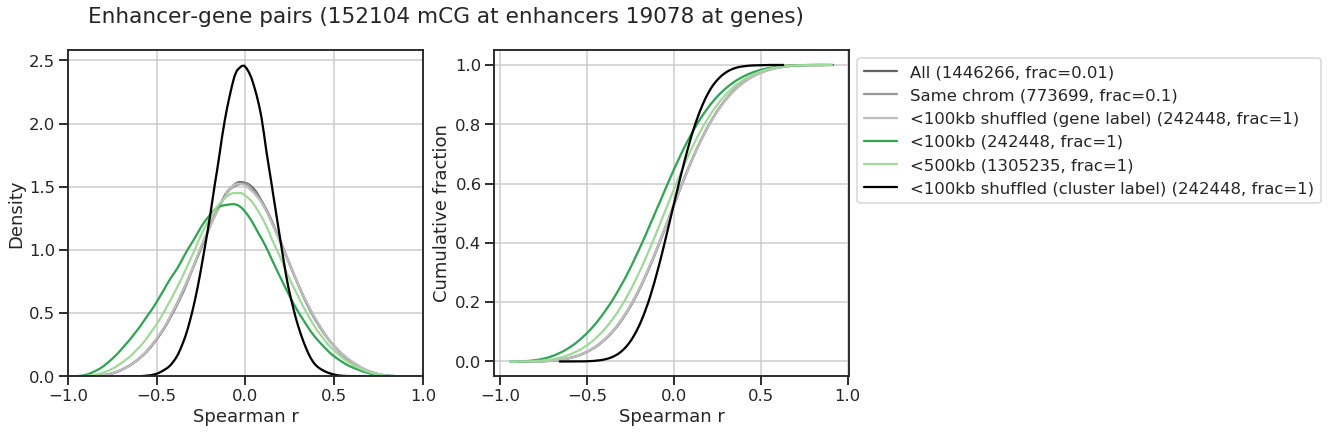

In [51]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks, labels, colors):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

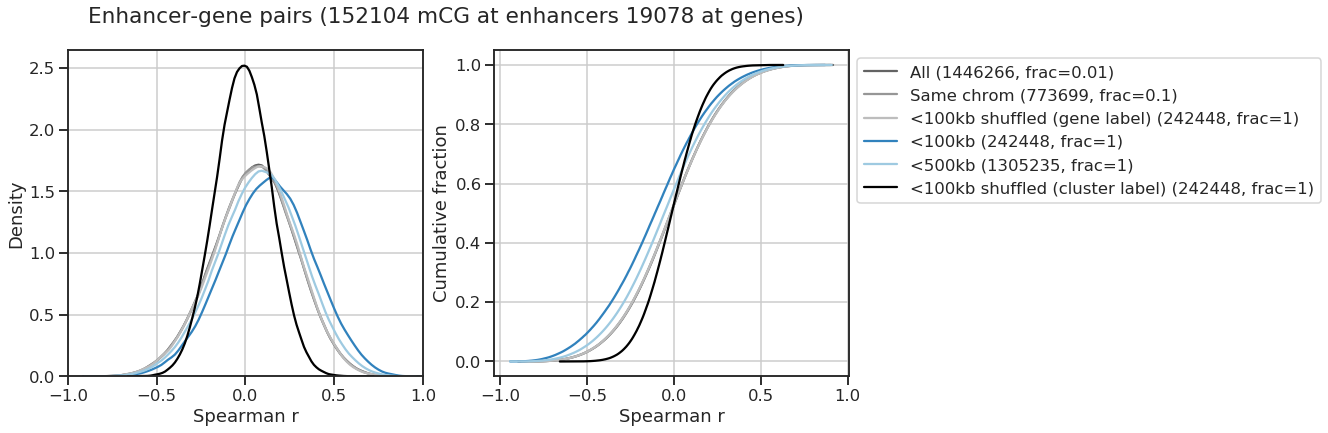

In [52]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks2, labels, colors2):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors2, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories2' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

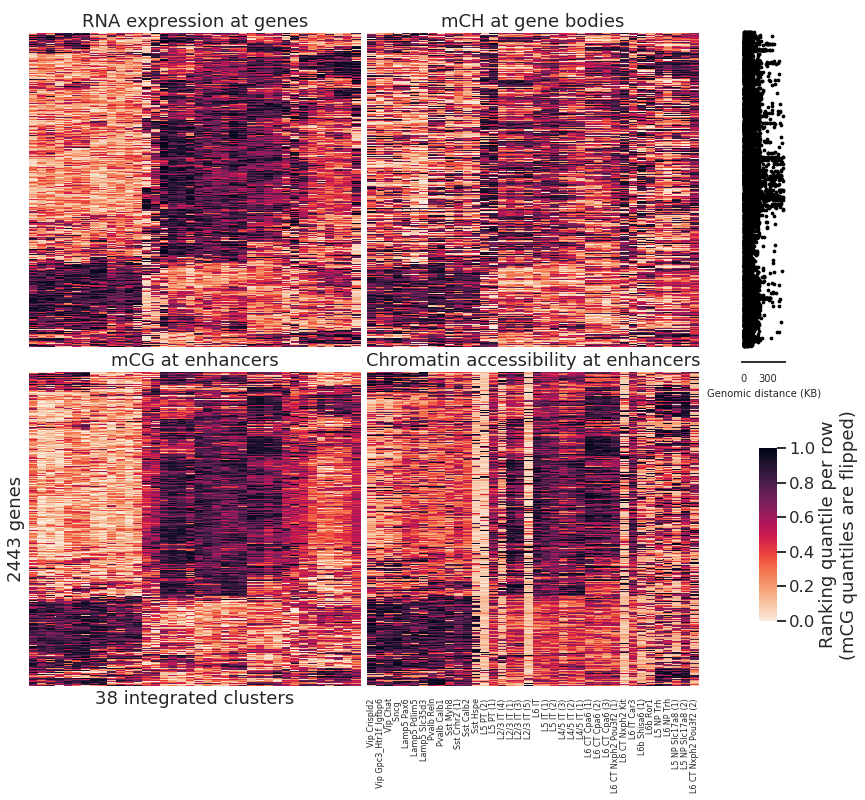

In [53]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket_r'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black',
               rasterized=True,
              )
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    rasterized=True,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes' 
    snmcseq_utils.savefig(fig, output_figures.format(output_name, 'pdf'))
    plt.show()

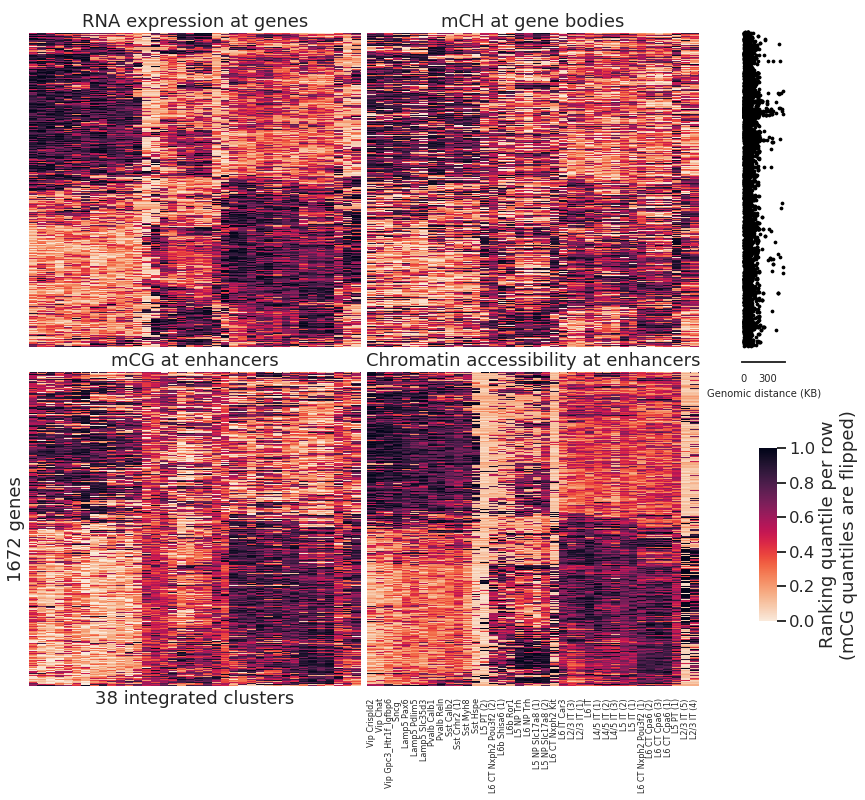

In [54]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket_r'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig2_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig2.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig2.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black', 
                rasterized=True,
              )
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    rasterized=True,
                    cmap=cmap,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes2' 
    snmcseq_utils.savefig(fig, output_figures.format(output_name, 'pdf'))
    plt.show()

In [ ]:
output_toevals = output_results.format('to_evals.tsv')
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)
print(to_evals.shape)

### one example correlation

In [56]:
def scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_gene_enh'):
    """
    """
    fontsize = 10
    
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5))
    ax = axs[0]
    _x = enh_mcg_clsts.loc[enh, clusters_selected]
    _y = gene_rna_clsts.loc[gene, clusters_selected]
    _c = pd.Series(clst_annot)[clusters_selected]
    print(_x.sort_values().index.tolist())
    ax.invert_xaxis()

    ax.scatter(_x.values, _y.values, c=mod_palette['mc'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
    for __x, __y, __c in zip(_x, _y, _c):
        if __y > 1:
            ax.text(__x, __y, __c, fontsize=fontsize)
    ax.set_xlabel('{}\nenhancer mCG'.format(enh_name))
    ax.set_ylabel('{} expression\nlog10(TPM+1)'.format(gid_to_name.loc[gene]))

    ax = axs[1]
    _x = enh_atac_clsts.loc[enh, clusters_selected]
    _y = gene_rna_clsts.loc[gene, clusters_selected]
    _c = pd.Series(clst_annot)[clusters_selected]

    ax.scatter(_x.values, _y.values, c=mod_palette['atac'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
    for __x, __y, __c in zip(_x, _y, _c):
        if __y > 1:
            ax.text(__x, __y, __c, fontsize=fontsize)
    ax.set_xlabel('enhancer ATAC\nlog10(RPM+1)')
    ax.set_ylabel('')

    fig.tight_layout()
    if output:
        fig.savefig(output_figures.format(output, 'pdf'), bbox_inches='tight')
    plt.show()

In [57]:
to_evals['val_both'] = to_evals['val'] + (-to_evals['val2'])

In [58]:
to_evals.sort_values('val_both').head()

gene     ens       val      val2  val_clustershuffled  \
439878   ENSMUSG00000022237   79089 -0.898676  0.822519             0.054163   
1423739  ENSMUSG00000039706  170709 -0.913776  0.805887            -0.027027   
759059   ENSMUSG00000027506  139228 -0.853376  0.858190            -0.011708   
518006   ENSMUSG00000023927  100766 -0.875698  0.833242             0.246088   
1362467  ENSMUSG00000038418  108089 -0.942007  0.754240            -0.060072   

         val2_clustershuffled   dist       pvalues  fdr<100kb  fdr<200kb  \
439878              -0.009957  37890  6.914357e-07   0.004446   0.007361   
1423739              0.149360   3839  6.914357e-07   0.010138   0.016620   
759059               0.008644   5536  2.250090e-05   0.022917   0.039214   
518006              -0.245213  27398  6.057458e-06   0.013163   0.021905   
1362467              0.094649   5700  6.914357e-07   0.691436   0.691436   

         fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  \
439878    0.017681                            0.691436  0.000020    0.032081   
1423739   0.039888                            0.691436  0.000050    0.051351   
759059    0.084905                           22.500903  0.000005    0.036397   
518006    0.049909                            6.057458  0.000012    0.026648   
1362467   0.691436                            0.691436  0.000270    0.097847   

         fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
439878     0.055854    0.109747                             3.939796 -1.721195  
1423739    0.086317    0.167602                             9.788774 -1.719663  
759059     0.061455    0.119208                             0.973136 -1.711566  
518006     0.046146    0.091110                             2.311060 -1.708940  
1362467    0.148316    0.262618                            52.629501 -1.696247

In [59]:
gene = 'ENSMUSG00000040133'
to_evals[to_evals['gene']==gene].sort_values('val').head()

gene     ens       val      val2  val_clustershuffled  \
1445247  ENSMUSG00000040133  132088 -0.832804  0.708283            -0.011052   
1445224  ENSMUSG00000040133  132054 -0.799759  0.560127            -0.018930   
1445249  ENSMUSG00000040133  132090 -0.762337  0.808732            -0.158989   
1445248  ENSMUSG00000040133  132089 -0.696903  0.838932            -0.066637   
1445237  ENSMUSG00000040133  132072 -0.687493  0.698435            -0.034905   

         val2_clustershuffled    dist   pvalues  fdr<100kb  fdr<200kb  \
1445247              0.067513   18922  0.000055   0.030409   0.051657   
1445224              0.190502  213432  0.000203   0.054288   0.086592   
1445249              0.116534    8988  0.000625   0.086532   0.132524   
1445248              0.056571    9799  0.002595   0.146820   0.212356   
1445237              0.280665   88300  0.003057   0.155031   0.222393   

         fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  \
1445247   0.110314                           55.085692  0.000800    0.130025   
1445224   0.174325                          202.720689  0.010820    0.271975   
1445249   0.248812                          625.238805  0.000043    0.047098   
1445248   0.359192                         2594.828309  0.000009    0.025600   
1445237   0.372342                         3056.704848  0.000995    0.138170   

         fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
1445247    0.189722    0.320015                           156.134719 -1.541088  
1445224    0.359188    0.523187                           189.926091 -1.359886  
1445249    0.079829    0.156162                             8.377125 -1.571069  
1445248    0.043790    0.086864                             1.776923 -1.535835  
1445237    0.200263    0.335082                           194.216377 -1.385928

In [60]:
gene = df_genes_v2.loc['Slc1a2', 'gid']
to_evals[to_evals['gene']==gene].sort_values('val').head()

gene     ens       val      val2  val_clustershuffled  \
87398  ENSMUSG00000005089  130616 -0.869789  0.616151             0.204727   
87391  ENSMUSG00000005089  130608 -0.850531  0.484626             0.287012   
87390  ENSMUSG00000005089  130607 -0.843747  0.544589             0.312835   
87393  ENSMUSG00000005089  130610 -0.817704  0.620527             0.180654   
87397  ENSMUSG00000005089  130614 -0.816391  0.629719             0.102309   

       val2_clustershuffled   dist   pvalues  fdr<100kb  fdr<200kb  fdr<500kb  \
87398              0.115658  25421  0.000009   0.016133   0.026975   0.060357   
87391             -0.058978  11277  0.000025   0.023733   0.040650   0.087685   
87390              0.012146  10295  0.000034   0.026072   0.044510   0.095613   
87393              0.187001  19639  0.000107   0.041116   0.067875   0.140921   
87397              0.171463  23514  0.000114   0.042343   0.069631   0.144114   

       fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
87398                            9.106275  0.004741    0.216057    0.296010   
87391                           25.338937  0.027284    0.354465    0.444643   
87390                           34.376741  0.013272    0.287851    0.376074   
87393                          107.101232  0.004423    0.212313    0.291679   
87397                          113.560206  0.003814    0.204948    0.283106   

       fdr2<500kb  fdr2<100kb shuffled (cluster label)  val_both  
87398    0.455384                           585.913072 -1.485939  
87391    0.602241                            43.636575 -1.335157  
87390    0.538700                           133.186530 -1.388336  
87393    0.450615                           559.047597 -1.438232  
87397    0.441294                           506.209914 -1.446110

Gpr176 chr5_18368064_18368187


KeyError: 168028

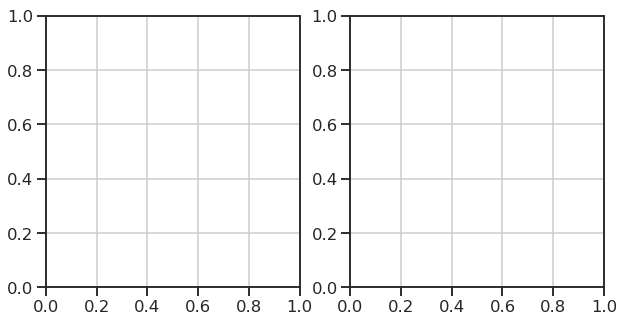

In [61]:
gene = 'ENSMUSG00000040133'
enh = 168028

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

In [ ]:
gene = 'ENSMUSG00000005089'
enh = 166180

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

## example for every cell type 

In [ ]:
for idx, row in to_evals.sort_values('val_both').head(10).iterrows():
    gene = row['gene']
    enh = row['ens']
    print(gene, enh)
    
    gene_name = gid_to_name.loc[gene]
    enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
    output = 'scatter_{}_{}'.format(gene, enh_name)
    print(gene_name, enh_name)
    scatter_gene_enh_example(gene, gene_name, enh, enh_name, output=output)
    

### Compare with nearest gene 

In [ ]:
print(top_sig.shape)
top_sig.head()

In [ ]:
regions_info.head()

In [ ]:
top_sig.head()

In [ ]:
def match_gene(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

In [ ]:
# get nn gene information
top_sig['nearest_gene'] = (regions_info.set_index('index')
                                       .loc[top_sig['ens'].values, 'gene_id']
                                       .apply(match_gene)
                                       .values
                          )

n_nngenes = (top_sig['gene'] == top_sig['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes, n_pair, n_nngenes/n_pair, n_pair-n_nngenes))
    
nontr_top_sig = top_sig.loc[(top_sig['gene'] != top_sig['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig.shape)
nontr_top_sig.head()

In [ ]:
# get nn gene information
top_sig2['nearest_gene'] = (regions_info.set_index('index')
                                       .loc[top_sig2['ens'].values, 'gene_id']
                                       .apply(match_gene)
                                       .values
                          )

n_nngenes2 = (top_sig2['gene'] == top_sig2['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes2, n_pair2, n_nngenes2/n_pair2, n_pair2-n_nngenes2))
    
nontr_top_sig2 = top_sig2.loc[(top_sig2['gene'] != top_sig2['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig2.shape)
nontr_top_sig2.head()

### nearest genes vs CICERO? 

- significant genes
- nearest genes
- agreed with cicero

In [ ]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[top_sig['gene']!=top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='Non-nearest gene ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['gene']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=1,
    label='Nearest gene ({})'.format(n),
)


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()

In [ ]:
# numbers 
track1 = [0, 
          len(top_sig[top_sig['gene']==top_sig['nearest_gene']]), 
          len(top_sig[top_sig['gene']!=top_sig['nearest_gene']]),
         ]
track1_colors = [mod_palette['mc'], 'lightgray']
# track1_colors = ['black', 'lightgray']
track1_labels = ['Nearest', 'Non-nearest']

track2 = [0, 
          len(top_sig2[top_sig2['gene']==top_sig2['nearest_gene']]), 
          len(top_sig2[top_sig2['gene']!=top_sig2['nearest_gene']]),
         ]
# track2_colors = ['black', 'lightgray']
track2_colors = [mod_palette['atac'], 'lightgray']
track2_labels = ['Nearest', 'Non-nearest']

fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
ax = axs[0]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.set_ylabel('Number')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()


ax = axs[1]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction')
snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))

fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
output_name = 'frac_nngenes' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
fig.tight_layout()

In [ ]:
a = to_evals.groupby('gene').size().sort_values() #.values
a = a.value_counts().sort_index() #.values

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(a.index.values, a.values)
    ax.set_xlabel('Number of enhancers within 1MB')
    ax.set_ylabel('Number of genes')
    ax2 = ax.twinx()
    ax2.plot(a.index.values, np.cumsum(a.values), color='C1', label='Cumulative')
    ax2.grid(False)
    ax2.set_ylabel('Cumulative number of genes')
    
    output_name = 'distribution-num-enhancers-per-gene' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')


In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1))
ax = axs[0]
for mod, _df in zip(['mc', 'atac'], 
                    [top_sig, top_sig2], 
                    ):
    a = _df.groupby('gene').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated enhancers')
ax.set_ylabel('Cumulative fraction of genes')
ax.set_xlim([0, 20])
ax.set_ylim([0, 1.05])

ax = axs[1]
for mod, _df in zip(['mc', 'atac'], 
                    [top_sig, top_sig2], 
                    ):
    a = _df.groupby('ens').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated genes')
ax.set_ylabel('Cumulative fraction of enhancers')
ax.set_xlim([0, 6.5])
ax.set_ylim([0, 1.05])



fig.tight_layout()
output_name = 'cdf_enh_per_gene' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')

## Number of enhancers and number of genes 

In [ ]:
print(len(to_evals['gene'].unique()))
print(len(to_evals['ens'].unique()))
print(enh_mcg_clsts.shape)

## Unorganized 

### super enhancers 
start from ```to_evals```
- statistics on gene - cumulative effect of enhancers

In [ ]:
th = -0.3
_tmp = to_evals.groupby('gene')
gene_score = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score = gene_score.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score.sort_values('val_score').head()

In [ ]:
_tmp = to_evals_shuffled.groupby('gene')
gene_score_shuffled = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score_shuffled = gene_score_shuffled.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score_shuffled.sort_values('val_score').head()

In [ ]:
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1)[:30])
# sns.distplot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1))
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score_shuffled.sort_values('val').index.values)].sum(axis=1)[:100])

In [ ]:
corr_tracks = np.array([
    gene_score_shuffled['val_score'].values,
    gene_score['val_score'].values,
])

labels = np.array([
    'Gene score shuffled',
    'Gene score',
])

colors = np.array([
    'C0',
    'C1',
])

subsample_rates = np.array([
    1,
    1,
])

In [ ]:
# FDR
bins_eval = np.linspace(-30, 0, 1000)

# background
x_bck = np.sort(corr_tracks[0])
y_bck = np.arange(len(x_bck))/len(x_bck)

# fore-ground - 1
x_fr = np.sort(corr_tracks[1])
y_fr = np.arange(len(x_fr))/len(x_fr)

# ratio 0
fdr_multi = fdr(bins_eval, x_bck, y_bck, x_fr, y_fr)

# plt.plot(bins_eval, fdr_multi)

    

In [ ]:
# plot
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('CDF')
    
    xmin, xmax, ymin, ymax = -1, 0.1, -0.01, 0.1
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    
    fig.suptitle('Gene scores ({} genes)'.format(len(gene_score)), 
                )
    
#     fig.tight_layout()
    output_name = '30-super-enhancers-score' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [ ]:
from matplotlib.patches import Rectangle
with sns.plotting_context('talk'):
    # inner box
#     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
    xmin, xmax, ymin, ymax = -3, 0, 0, 0.3 
    
    fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
    ax = axs[0]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
#     ax.set_xlim([xmin_1, xmax_1])
#     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('FDR')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

    ax = axs[1]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.axhline(0.05, color='black', linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    output_name = '31-super-enhancers-fdrs' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [ ]:
th = 0.3
gene_score['fdr'] = gene_score['val_score'].apply(lambda x: fdr(x, x_bck, y_bck, x_fr, y_fr))
res_multi = gene_score[gene_score['fdr']<th].sort_values('val_score')
print(res_multi.shape)
res_multi.head()

### Lots of heatmaps 

In [ ]:
th2 = -0.3
to_plot = to_evals[to_evals['val']<th2] 

to_plot.shape
to_plot.head()

In [ ]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    ax = axs[0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
#                     xticklabels=False,
                    yticklabels=True,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                   )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

    ax = axs[1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at putative super-enhancers')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[2]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[3]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
    output_name = '32-heatmap-examples-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [ ]:
gene = 'Kcnc1'
gid = df_genes.groupby('gene_name').first().loc[gene, 'gid']
gid

In [ ]:
# heatmap of gene by cluster

cmap = 'rocket'
gene = 'Kcnc1'
gene = df_genes.groupby('gene_name').first().loc[gene, 'gid']

# rna at genes 
rna_mat = gene_rna_clsts.loc[[gene], clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)


# ordered
ens_ordered = to_plot.set_index('gene').loc[gene]
clst_idx_ordered = np.argsort(rna_mat_norm.values.flatten())

# mCH at genes
mch_mat = gene_mch_clsts.loc[[gene], clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# organize heatmap to plot
n_repeats = 3
blank_repeats = 1

heatmap_all = np.vstack([
    # mcg
    (1-mcc_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered],    
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # atac
     atac_mat.rank(axis=1, pct=True).iloc[:, clst_idx_ordered],
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # rna
    np.repeat(rna_mat_norm.iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # mch
    np.repeat((1-mch_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
])

yticklabels = np.hstack([
    ['Enhancer mCG']*(len(mcc_mat) + blank_repeats),
    ['Enhancer ATAC']*(len(atac_mat) + blank_repeats),
    ['RNA']*(n_repeats + blank_repeats),
    ['Genebody mCH']*n_repeats,
])
yticklabels = snmcseq_utils.dedup_array_elements(yticklabels)

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(8,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    g = sns.heatmap(heatmap_all, 
                    xticklabels=clusters_selected_labels[clst_idx_ordered],
                    yticklabels=yticklabels, 
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel('{} integrated clusters'.format(mcc_mat.shape[1]))
    ax.set_title('{} enhancers correlated with {}'.format(len(mcc_mat), gid_to_name.loc[gene]))
    
    output_name = '33-heatmap-1example-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.subplots_adjust(wspace=0.02, hspace=0.08)
    plt.show()

In [ ]:
# bed = regions.set_index('index').loc[ens_ordered['ens'].values].reset_index()[['chrom', 'start', 'end', 'index']]
# bed.to_csv('/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/kcnc1_enhancers.tsv', 
#            sep='\t', na_rep='NA',
#            header=False, index=False, 
#           )

In [ ]:
# bed['len'] = bed['end'] - bed['start']
# bed.sort_values('len').tail()

### Compare with CICERO findings 

In [ ]:
print(f)

In [ ]:
# CICERO enhancers -> genes
f = os.path.join(data_dir, 'ref/cicero_enhancer_gene_mm10_nochr.bed')
cicero_to_gene = pd.read_csv(f, sep='\t', header=None, names=['chrom', 'start', 'end', 'index', 'gene'])
cicero_to_gene['chrom'] = cicero_to_gene['chrom'].apply(lambda x: 'chr'+str(x))
print(cicero_to_gene.shape)
cicero_to_gene.head()

In [ ]:
# enhancers -> CICERO enhancers 

f = os.path.join(data_dir, 'results/enhancer_cicero_overlap.bed')
ens_to_cicero = pd.read_csv(f, sep="\t", header=None, 
                            names=['chrom', 'start', 'end', 'name', 
                                    'chrom_cicero', 'start_cicero', 'end_cicero', 'overlap'
                                   ])
print(ens_to_cicero.shape)
ens_to_cicero.head()


In [ ]:
# enhancers -> cicero enhancers -> cicero_genes # long, a few minutes
_cicero = cicero_to_gene.set_index(['chrom', 'start', 'end'])
def get_gene_from_cicero(row, cicero):
    """
    """
    chrom, start, end = row[['chrom_cicero', 'start_cicero', 'end_cicero']].tolist()
    genes = cicero.loc[(chrom, start, end), 'gene'].values
    return genes
    
ens_to_cicero['gene_cicero'] = ens_to_cicero.apply(lambda x: get_gene_from_cicero(x, _cicero), axis=1)
print(ens_to_cicero.shape)
ens_to_cicero.head()

In [ ]:
# Compare with our prediction
top_sig_chr = top_sig.copy() 
top_sig_chr['chrom'] = top_sig_chr['chrom'].apply(lambda x: 'chr'+str(x))

comp_cicero = pd.merge(top_sig_chr, ens_to_cicero, on=['chrom', 'start', 'end'])
print(top_sig_chr.shape, ens_to_cicero.shape, comp_cicero.shape)
comp_cicero.head()

In [ ]:
def check_agree(row):
    """
    """
    return (row['gene_name'] in row['gene_cicero'].tolist())

###
gid_to_name = df_genes.set_index('gid')['gene_name']
def check_agree_gid(row):
    """
    """
    return (gid_to_name.loc[row['gene']] in row['gene_cicero'].tolist())
### 

comp_cicero['agree?'] = comp_cicero.apply(check_agree, axis=1)
n_genes_avg = comp_cicero['gene_cicero'].apply(len).mean()

n_overlap = len(comp_cicero)
n_agree = comp_cicero['agree?'].sum()
n_test = comp_cicero.shape[0]
print(
    "{}/{}={:.2f} enhancer-gene pairs whose enhancers overlap with CICERO enhancers, {}/{}={:.2f} of them agree with CICERO prediction."
    .format(n_overlap, n_pair, n_overlap/n_pair, n_agree, n_test, n_agree/n_test))

comp_cicero[comp_cicero['agree?']].head()